In [1]:
# utility imports
import os
import numpy as np
import pandas as pd

#env imports
import gym
from pettingzoo.butterfly import cooperative_pong_v2
import supersuit as ss

#Algoritm Imports
from stable_baselines3.ppo import CnnPolicy
from stable_baselines3 import PPO, A2C, DQN



In [16]:
env = cooperative_pong_v2.parallel_env(ball_speed=9, left_paddle_speed=12, right_paddle_speed=12, cake_paddle=False, max_cycles=2000, bounce_randomness=False) #create env
agents= ['paddle_0', 'paddle_1'] #name agents
env = ss.color_reduction_v0(env, mode='B') #convert to grayscale for less computation
env = ss.resize_v0(env, x_size=84, y_size=84) #resive
env = ss.frame_stack_v1(env, 4)#stack 4 frames together to see velocity/direction
env = ss.pettingzoo_env_to_vec_env_v0(env) #convert to vec env
env = ss.concat_vec_envs_v0(env, 1, num_cpus=1, base_class='stable_baselines3') #parallelize

In [17]:
model = PPO(CnnPolicy, env,  learning_rate=0.0003, n_steps=2048, batch_size=64, n_epochs=10, gamma=0.99, gae_lambda=0.95, clip_range=0.2,
            clip_range_vf=1, ent_coef=0.0, vf_coef=0.5, max_grad_norm=0.5, use_sde=False, sde_sample_freq=- 1, target_kl=None, 
            tensorboard_log=None, create_eval_env=False, policy_kwargs=None, verbose=1, seed=314, device='auto', _init_setup_model=True)

Using cpu device
Wrapping the env in a VecTransposeImage.


In [18]:
os.chdir('log')

In [20]:
for steps in range(2048,(20480*5),2048):
    model.learn(total_timesteps = steps)
    
    policy = str(steps)
    model.save(policy)
    print(policy + ' complete!')

-----------------------------
| time/              |      |
|    fps             | 618  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 4096 |
-----------------------------
2048 complete!
------------------------------------------
| time/                   |              |
|    fps                  | 505          |
|    iterations           | 1            |
|    time_elapsed         | 8            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | -0.014404828 |
|    clip_fraction        | 0.144        |
|    clip_range           | 0.2          |
|    clip_range_vf        | 1            |
|    entropy_loss         | -1.09        |
|    explained_variance   | -6.46e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 143          |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0234      |
|    value_loss           | 289          |
-

In [24]:
#set up test env
env1 = cooperative_pong_v2.parallel_env(ball_speed=9, left_paddle_speed=12, right_paddle_speed=12, cake_paddle=False, max_cycles=2000, bounce_randomness=False) #create env
agents= ['paddle_0', 'paddle_1'] #name agents
env1 = ss.color_reduction_v0(env1, mode='B') #convert to grayscale for less computation
env1 = ss.resize_v0(env1, x_size=84, y_size=84) #resive
env1 = ss.frame_stack_v1(env1, 4)#stack 4 frames together to see velocity/direction
env1 = ss.pettingzoo_env_to_vec_env_v0(env1) #convert to vec env
env1 = ss.concat_vec_envs_v0(env1, 1, num_cpus=0, base_class='stable_baselines3') #parallelize, only 1 env

In [22]:
results = pd.DataFrame(columns = ['num_training_steps', 'avg_reward'])

In [25]:
num_episodes = range(100)

for count, filename in enumerate(os.listdir()):
    if filename.endswith(".zip"):
        model = PPO.load(filename.split('.')[0], env=env1)
        reward_per_ep = []

        for ep in num_episodes:

            rewards = []
            steps = 0


            obs = env1.reset()
            done = np.array([0,0])

            while all(done) != 1:
                action, _states = model.predict(obs)
                obs, reward, done, info = env1.step(action)
                steps+=1
                rewards.append(reward[0])

            reward_per_ep.append(sum(rewards)/len(rewards))


        results = results.append({'num_training_steps' : int(filename.split('.')[0]), 'avg_reward' : sum(reward_per_ep)/len(reward_per_ep)}, ignore_index = True)

Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Wrapping the env in a VecTransposeImage.
Wrapping the env

In [ ]:
os.chdir('..')

In [27]:
results.sort_values(by=['num_training_steps'])
results.to_csv('results.csv')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
results = pd.read_csv('results.csv')
results['algorithm'] = 'PPO'

In [9]:
results.sort_values(by=['num_training_steps'])
#results

,num_training_steps,avg_reward,algorithm
6,2048,-1.126019,PPO
17,4096,-1.129832,PPO
28,6144,-1.190822,PPO
39,8192,-1.116408,PPO
1,10240,-1.086567,PPO
2,12288,-1.103114,PPO
3,14336,-0.968771,PPO
4,16384,-1.136953,PPO
5,18432,-1.042290,PPO
7,20480,-1.056390,PPO


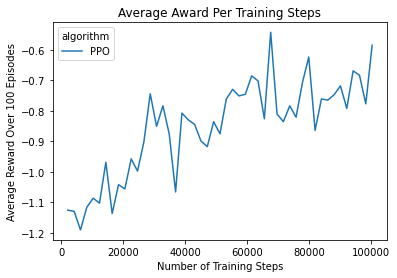

In [34]:
sns.lineplot(x=results.num_training_steps, y=results.avg_reward, hue=results.algorithm );
plt.title('Average Award Per Training Steps');
plt.xlabel('Number of Training Steps');
plt.ylabel('Average Reward Over 100 Episodes');